# English-to-French translation by Encoder-Decoder

In this notebook, I used the Encoder-Decoder architecture to translate the English sentences into French.

---
**The dataset**

This notebook uses the dataset provided by [Udacity's NLP Nanodegree Course](https://www.udacity.com/course/natural-language-processing-nanodegree--nd892). The dataset is a subset extracted from the [WMT](http://www.statmt.org/) dataset. It contains 137,861 English sentences and their translations in French.

To run this notebook, simply upload the training data onto the Google Colab workspace (assuming that you have those files). If you don't have the files I used, you can upload your own dataset (even in different languages), and rewrite your data preprocessing codes.

---
**Computing resource**

This notebook was run on Google Colab

# Import libraries

In [1]:
%matplotlib inline

import os

import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, GRU, Input, Dense, TimeDistributed, Activation
from tensorflow.keras.layers import RepeatVector, Bidirectional, Attention, Concatenate, Dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

import matplotlib.pyplot as plt


"""
The code below is used to confirm that we're using GPU
"""

print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print("\n")

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

2.3.0
Found GPU at: /device:GPU:0


Sat Oct 31 18:06:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    38W / 300W |    433MiB / 16130MiB |      2%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                    

# Load the dataset

Load the dataset (it could be your own dataset) from the working directory

In [2]:
## Load English sentences
with open('small_vocab_en', 'r') as f:
    eng_raw_data = f.read()
          
english_sentences = eng_raw_data.split('\n')

## Load French sentences
with open('small_vocab_fr', 'r') as f:
    fr_raw_data = f.read()
          
french_sentences = fr_raw_data.split('\n')

In [3]:
## Display some info

print("sentences in the English corpus: {}".format(len(english_sentences)))
print("sentences in the French corpus: {}".format(len(french_sentences)))

print("\n")

print("first 3 English/French sentences:\n")

for i in range(3):
    print(english_sentences[i])
    print(french_sentences[i])
    print("\n")

sentences in the English corpus: 137861
sentences in the French corpus: 137861


first 3 English/French sentences:

new jersey is sometimes quiet during autumn , and it is snowy in april .
new jersey est parfois calme pendant l' automne , et il est neigeux en avril .


the united states is usually chilly during july , and it is usually freezing in november .
les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


california is usually quiet during march , and it is usually hot in june .
california est généralement calme en mars , et il est généralement chaud en juin .




We use `collections.Counter` to count the distinct words in both languages, and use the `most_common()` method to see the most frequently used words

In [4]:
from collections import Counter

## Size of the English vocabulary
english_corpus = [w for sentence in english_sentences for w in sentence.split()]
english_vocab_counter = Counter(english_corpus)
english_vocab_size = len(english_vocab_counter)

print("Size of the English corpus: {}".format(len(english_corpus)))
print("Vocab size of English: {}".format(english_vocab_size))
print("10 most frequent English vocab: {}".format([x[0] for x in english_vocab_counter.most_common(10)]))
print("longest length of sentence: {}".format(max(len(sentence.split()) for sentence in english_sentences)))
print("\n")

## Size of the French vocabulary
french_corpus = [w for sentence in french_sentences for w in sentence.split()]
french_vocab_counter = Counter(french_corpus)
french_vocab_size = len(french_vocab_counter)

print("Size of the French corpus: {}".format(len(french_corpus)))
print("Vocab size of French: {}".format(french_vocab_size))
print("10 most frequent French vocab: {}".format([x[0] for x in french_vocab_counter.most_common(10)]))
print("longest length of sentence: {}".format(max(len(sentence.split()) for sentence in french_sentences)))

Size of the English corpus: 1823250
Vocab size of English: 227
10 most frequent English vocab: ['is', ',', '.', 'in', 'it', 'during', 'the', 'but', 'and', 'sometimes']
longest length of sentence: 17


Size of the French corpus: 1961295
Vocab size of French: 355
10 most frequent French vocab: ['est', '.', ',', 'en', 'il', 'les', 'mais', 'et', 'la', 'parfois']
longest length of sentence: 23


We see that the longest length of English sentences is 17, and the longest length of French sentences is 23

# Create training, validation, and test datasets

We use `sklearn.model_selection.train_test_split` split the dataset (137,861 sentences) into:

- training dataset of 120,000 sentences,

- validation dataset of 7,861 sentences, and

- test dataset of 10,000 sentences

In [5]:
## Split into 120000 training, 7861 validation, and 10000 test data

from sklearn.model_selection import train_test_split

# separate test data
X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(english_sentences, french_sentences, test_size = 10000, random_state = 1)

# separate train and validation data
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_valid, Y_train_valid, test_size = 7861, random_state = 1)

# check sizes
print("number of training data: {} / {}".format(len(X_train), len(Y_train)))
print("number of valid data: {} / {}".format(len(X_valid), len(Y_valid)))
print("number of test data: {} / {}".format(len(X_test), len(Y_test)))


number of training data: 120000 / 120000
number of valid data: 7861 / 7861
number of test data: 10000 / 10000


# Build TensorFlow input pipelines

Use `tf.data.Dataset.from_tensor_slices` to convert the data into tensorflow dataset

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

next(iter(train_dataset))

(<tf.Tensor: shape=(), dtype=string, numpy=b'california is usually hot during july , and it is never wet in april .'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'californie est g\xc3\xa9n\xc3\xa9ralement chaud en juillet , et il est jamais humide en avril .'>)

In [7]:
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))

next(iter(valid_dataset))

(<tf.Tensor: shape=(), dtype=string, numpy=b'paris is dry during august , and it is usually beautiful in july .'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b"paris est sec au mois d' ao\xc3\xbbt , et il est g\xc3\xa9n\xc3\xa9ralement beau en juillet .">)

In [8]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

next(iter(test_dataset))

(<tf.Tensor: shape=(), dtype=string, numpy=b'california is sometimes warm during fall , and it is usually beautiful in april .'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b"californie est parfois chaud pendant l' automne , et il est g\xc3\xa9n\xc3\xa9ralement beau en avril .">)

# Tokenize the words

We use the method `build_from_corpus` of `tfds.deprecated.text.SubwordTextEncoder` to tokenize the English and French sentences

The [SubwordTextEncoder](https://www.tensorflow.org/datasets/api_docs/python/tfds/deprecated/text/SubwordTextEncoder) can encode a word by its subwords if that word was not seen in its dictionaty.

We specified the `vocab_size` so that the tokens wll give integers from [1, vocab_size)


In [9]:
## Subword Tokenizer
english_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus((eng.numpy() for eng, fr in train_dataset), target_vocab_size = 2**13)
french_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus((fr.numpy() for eng, fr in train_dataset), target_vocab_size = 2**13)


## Vocabulary size (+2 for start and end)
input_vocab_size = english_tokenizer.vocab_size + 2
output_vocab_size = french_tokenizer.vocab_size + 2

The test below will tokenize an English sentence into tokens by the `encode` method of the tokenizer. The token will then be decoded back by using the `decode` method. After decoding we should get the original sentence

In [10]:
## Test the tokenization

sample_sentence = X_valid[100]

encoded_sample_sentence = english_tokenizer.encode(sample_sentence)

print("input sentence: {}".format(sample_sentence))
print("tokens: {}".format(encoded_sample_sentence))
print("tokenized sentence: {}".format(english_tokenizer.decode(encoded_sample_sentence)))
print("\n")

print("detail of tokenizing:")
for k in encoded_sample_sentence:
    print("{} ---> {}".format(k, english_tokenizer.decode([k])))

print("\n")
## More sanity check on the first 5 sentences in the training dataset
for i in range(5):
    print(X_train[i] == english_tokenizer.decode(english_tokenizer.encode(X_train[i])))

input sentence: the pear is your most loved fruit , but the grapefruit is her most loved .
tokens: [7, 107, 1, 31, 15, 27, 16, 2, 8, 7, 92, 1, 34, 15, 89, 3]
tokenized sentence: the pear is your most loved fruit , but the grapefruit is her most loved .


detail of tokenizing:
7 ---> the 
107 ---> pear 
1 ---> is 
31 ---> your 
15 ---> most 
27 ---> loved 
16 ---> fruit
2 --->  , 
8 ---> but 
7 ---> the 
92 ---> grapefruit 
1 ---> is 
34 ---> her 
15 ---> most 
89 ---> loved
3 --->  .


True
True
True
True
True


# The tokenize+pad function

The tokenize function takes a list of sentences and its language tokenizer as inputs. It tokenizes the sentences, and add a **start token** and an **end token** in each sentence

There are in total N tokens in the tokenizer, with labels from 1 to N-1.

We use **N as the start token**, and **N+1 as the end token**.

To get N, we use the `vocab_size` attribute of the tokenizer

In [11]:
MAX_LENGTH = 25             # maximum length of the input sentence
BUFFER_SIZE = 20000         # the size of the shuffle buffer
BATCH_SIZE = 64             # the batch size


def tokenize(eng_sentence, fr_sentence):

    eng_sentence = [english_tokenizer.vocab_size] + english_tokenizer.encode(eng_sentence.numpy()) + [english_tokenizer.vocab_size+1]
    fr_sentence =  [french_tokenizer.vocab_size] + french_tokenizer.encode(fr_sentence.numpy()) + [french_tokenizer.vocab_size+1]

    return eng_sentence, fr_sentence


def tf_tokenize(eng_sentence, fr_sentence):

    res_eng, res_fr = tf.py_function(tokenize, [eng_sentence, fr_sentence], [tf.int64, tf.int64])

    res_eng.set_shape([None])
    res_fr.set_shape([None])

    return res_eng, res_fr


def filter_max_length(x, y, max_length = MAX_LENGTH):

    return tf.logical_and(tf.size(x) <= max_length, tf.size(y) <= max_length)


## Propress the training data

The code below tokenizes, add SOS & EOS, filter out sentences that are too long

In [12]:
# tokenize the training dataset
train_dataset = train_dataset.map(tf_tokenize)
# remove sentences that are too long
train_dataset = train_dataset.filter(filter_max_length)
# cache the data to memory
train_dataset = train_dataset.cache()
# shuffle
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
# padding
train_dataset = train_dataset.padded_batch(BATCH_SIZE, padded_shapes = ([MAX_LENGTH], [MAX_LENGTH]))
# prefetching
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


# see a batch
eng_batch, fr_batch = next(iter(train_dataset))
eng_batch, fr_batch

(<tf.Tensor: shape=(64, 25), dtype=int64, numpy=
 array([[528,  23,   1, ...,   0,   0,   0],
        [528,  21,   1, ...,   0,   0,   0],
        [528,  33,  15, ...,   0,   0,   0],
        ...,
        [528,   7,  19, ...,   0,   0,   0],
        [528,  21,   1, ...,   0,   0,   0],
        [528,  24,   1, ...,   0,   0,   0]])>,
 <tf.Tensor: shape=(64, 25), dtype=int64, numpy=
 array([[717,  64,   1, ...,   0,   0,   0],
        [717,  31,   1, ...,   0,   0,   0],
        [717,  22, 121, ...,   0,   0,   0],
        ...,
        [717,   6,  32, ...,   0,   0,   0],
        [717, 569,  10, ...,   0,   0,   0],
        [717,   9,  35, ...,   0,   0,   0]])>)

## Preprocess the validation data

In [13]:
# tokenize the valid dataset
valid_dataset = valid_dataset.map(tf_tokenize)
# remove sentences that are too long
valid_dataset = valid_dataset.filter(filter_max_length)
# cache the data to memory
valid_dataset = valid_dataset.cache()
# shuffle
valid_dataset = valid_dataset.shuffle(BUFFER_SIZE)
# padding
valid_dataset = valid_dataset.padded_batch(BATCH_SIZE, padded_shapes = ([MAX_LENGTH], [MAX_LENGTH]))
# prefetching
valid_dataset = valid_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# see a batch
eng_batch, fr_batch = next(iter(valid_dataset))
eng_batch, fr_batch

(<tf.Tensor: shape=(64, 25), dtype=int64, numpy=
 array([[528,  24,   1, ...,   0,   0,   0],
        [528,  24,   1, ...,   0,   0,   0],
        [528,  30,  72, ...,   0,   0,   0],
        ...,
        [528,  28,  73, ...,   0,   0,   0],
        [528,  20,   1, ...,   0,   0,   0],
        [528,  26,   1, ...,   0,   0,   0]])>,
 <tf.Tensor: shape=(64, 25), dtype=int64, numpy=
 array([[717,  35,   1, ...,   0,   0,   0],
        [717,   9,  35, ...,   0,   0,   0],
        [717,   5,  29, ...,   0,   0,   0],
        ...,
        [717,  30,  29, ...,   0,   0,   0],
        [717,  34,   1, ...,   0,   0,   0],
        [717,  38,   1, ...,   0,   0,   0]])>)

## Preprocess the test data

In [14]:
# tokenize the test dataset
test_dataset = test_dataset.map(tf_tokenize)
# remove sentences that are too long
test_dataset = test_dataset.filter(filter_max_length)
# cache the data to memory
test_dataset = test_dataset.cache()
# shuffle
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
# padding
test_dataset = test_dataset.padded_batch(1, padded_shapes = ([MAX_LENGTH], [MAX_LENGTH]))
# prefetching
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# see a batch
eng_batch, fr_batch = next(iter(test_dataset))
eng_batch, fr_batch

(<tf.Tensor: shape=(1, 25), dtype=int64, numpy=
 array([[528,  30,  73,  84,   2,  77,   2,   9,  79,   3, 529,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>,
 <tf.Tensor: shape=(1, 25), dtype=int64, numpy=
 array([[717,   5, 571, 500,  29,   6,  79,   3,   6,  63,   8,   6,  78,
           2, 718,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>)

## Encoder-Decoder Architecture

The NN architecture contains:

1. Embedding
2. Bidirectional GRU
3. RepeatVector layer
4. Birirectional GRU
5. TimeDistributed layer
6. Softmax activation

In [15]:
class EncoderDecoder(tf.keras.layers.Layer):

    def __init__(self, rnn_class, output_dim, embedding_dim, encoder_units, decoder_units, input_vocab_size, output_vocab_size):

        super(EncoderDecoder, self).__init__()

        self.Embedding = Embedding(input_vocab_size, embedding_dim)

        if rnn_class.upper() == "GRU":
            self.Bidirectional_encoder = Bidirectional(GRU(encoder_units))
            self.Bidirectional_decoder = Bidirectional(GRU(decoder_units, return_sequences = True))
        elif rnn_class.upper() == "LSTM":
            self.Bidirectional_encoder = Bidirectional(LSTM(encoder_units))
            self.Bidirectional_decoder = Bidirectional(LSTM(decoder_units, return_sequences = True))
        
        self.RepeatVector = RepeatVector(output_dim)

        self.TimeDistributed = TimeDistributed(Dense(output_vocab_size))

        self.Activation = Activation('softmax')


    def call(self, x):

        x = self.Embedding(x)
        x = self.Bidirectional_encoder(x)
        x = self.RepeatVector(x)
        x = self.Bidirectional_decoder(x)
        x = self.TimeDistributed(x)
        y = self.Activation(x)

        return y

## Optimizer and Loss function

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3, beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)

loss_criterion = tf.keras.losses.SparseCategoricalCrossentropy(name = 'sparse_categorical_crossentropy')

# Training

In [17]:
train_step_signature = [tf.TensorSpec(shape=(None, None), dtype = tf.int64), tf.TensorSpec(shape=(None, None), dtype = tf.int64)]

@tf.function(input_signature = train_step_signature)
def train_step(input, target):

    with tf.GradientTape() as tape:

        preds = translator(input)

        loss = loss_criterion(target, preds)

    gradients = tape.gradient(loss, translator.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, translator.trainable_variables))

    train_loss(loss)
    train_acc(target, preds)


In [18]:
valid_step_signature = [tf.TensorSpec(shape=(None, None), dtype = tf.int64), tf.TensorSpec(shape=(None, None), dtype = tf.int64)]

@tf.function(input_signature = valid_step_signature)
def valid_step(input, target):

    preds = translator(input, training = False)

    loss = loss_criterion(target, preds)

    valid_loss(loss)
    valid_acc(target, preds)

In [19]:
import time

EPOCHS = 20

train_loss_history = []
valid_loss_history = []


## Create the translator
translator = EncoderDecoder(rnn_class = 'GRU', output_dim = MAX_LENGTH, embedding_dim = 256, encoder_units = 128, decoder_units = 128, input_vocab_size = input_vocab_size, output_vocab_size = output_vocab_size)

## Initialize metrics
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_acc')

valid_loss = tf.keras.metrics.Mean(name = 'valid_loss')
valid_acc = tf.keras.metrics.SparseCategoricalAccuracy(name = 'valid_acc')


for epoch in range(1, EPOCHS+1):

    start = time.time()

    train_loss.reset_states()
    train_acc.reset_states()

    

    for (batch, (input, target)) in enumerate(train_dataset):

        train_step(input, target)
        
        if batch % 500 == 0:
            
            for (_, (valid_x, valid_y)) in enumerate(valid_dataset):

                valid_step(valid_x, valid_y)


            print("Epoch {}\t Batch {}\t Loss {:.4f}\t Acc {:.4f}".format(epoch, batch, train_loss.result(), train_acc.result()))
    

    print("\n")
    print("Epoch {}\t Loss {:.4f}\t Acc {:.4f}\t  Val_Loss {:.4f}\t Val_Acc {:.4}\t Time: {:.1f} s".format(epoch, train_loss.result(), train_acc.result(),
                                                                                   valid_loss.result(), valid_acc.result(), time.time() - start))

    print("\n")

    train_loss_history.append(train_loss.result())
    valid_loss_history.append(valid_loss.result())


Epoch 1	 Batch 0	 Loss 6.5704	 Acc 0.0025
Epoch 1	 Batch 500	 Loss 2.1749	 Acc 0.5020
Epoch 1	 Batch 1000	 Loss 1.7313	 Acc 0.5758
Epoch 1	 Batch 1500	 Loss 1.5061	 Acc 0.6180


Epoch 1	 Loss 1.3912	 Acc 0.6406	  Val_Loss 2.5448	 Val_Acc 0.5786	 Time: 414.98253202438354 s


Epoch 2	 Batch 0	 Loss 0.8094	 Acc 0.7469
Epoch 2	 Batch 500	 Loss 0.8388	 Acc 0.7555
Epoch 2	 Batch 1000	 Loss 0.7943	 Acc 0.7678
Epoch 2	 Batch 1500	 Loss 0.7513	 Acc 0.7793


Epoch 2	 Loss 0.7238	 Acc 0.7866	  Val_Loss 1.6576	 Val_Acc 0.6765	 Time: 397.57235074043274 s


Epoch 3	 Batch 0	 Loss 0.5517	 Acc 0.8331
Epoch 3	 Batch 500	 Loss 0.5507	 Acc 0.8330
Epoch 3	 Batch 1000	 Loss 0.5225	 Acc 0.8409
Epoch 3	 Batch 1500	 Loss 0.4935	 Acc 0.8496


Epoch 3	 Loss 0.4718	 Acc 0.8564	  Val_Loss 1.2759	 Val_Acc 0.7328	 Time: 402.11424231529236 s


Epoch 4	 Batch 0	 Loss 0.3314	 Acc 0.8994
Epoch 4	 Batch 500	 Loss 0.3384	 Acc 0.9009
Epoch 4	 Batch 1000	 Loss 0.3142	 Acc 0.9090
Epoch 4	 Batch 1500	 Loss 0.2941	 Acc 0.9151

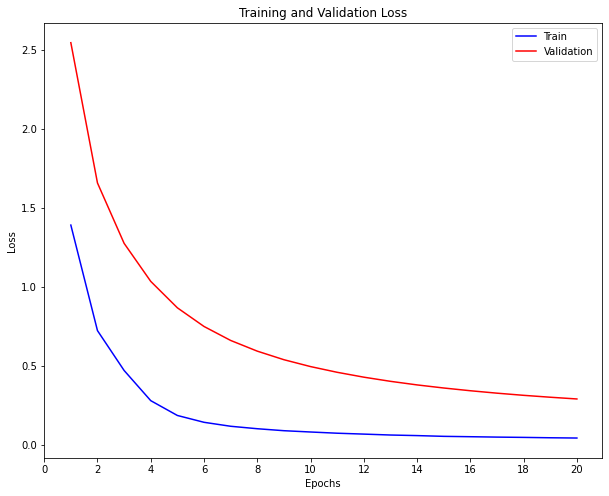

In [87]:
## Plot training and validation loss

plt.figure(figsize = (10, 8))
plt.plot(range(1, EPOCHS+1), train_loss_history, 'b', label = "Train")
plt.plot(range(1, EPOCHS+1), valid_loss_history, 'r', label = "Validation")
plt.xlabel("Epochs")
plt.xticks(range(0, 21, 2))
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Model Evaluation

## Bleu score

In [59]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [81]:
## Evaluation

# The test dataset has 10,000 sentence pairs

test_bleu_score = 0

smoothing_func = SmoothingFunction()

test_acc_func = tf.keras.metrics.SparseCategoricalAccuracy()

for (test_n, (test_x, test_y)) in enumerate(test_dataset):

    # prediction (logits)
    pred = translator(test_x, training = False)

    # Accuracy
    test_acc_func(test_y, pred)

    # Squeeze for further processing
    pred = tf.squeeze(pred).numpy()

    # prediction (tokens)
    pred_tokens = tf.math.argmax(pred, axis = 1)

    # convert to a list of words
    translation = french_tokenizer.decode([w for w in pred_tokens if w < french_tokenizer.vocab_size and w != 0]).split()

    # true translation
    references = french_tokenizer.decode([w for w in tf.squeeze(test_y).numpy() if w < french_tokenizer.vocab_size and w != 0]).split()

    # BLEU
    test_bleu_score += sentence_bleu(references = [references], hypothesis = translation, smoothing_function = smoothing_func.method1)

    

    if (test_n + 1) % 1000 == 0:
        print("Test data loaded ({}/10000)".format(test_n+1))


print("Test data n = {}".format(test_n))
print("Test BLEU score = {:4f}".format(test_bleu_score/(test_n+1)))
print("Test acc = {:4f}".format(test_acc_func.result()))

Test data loaded (1000/10000)
Test data loaded (2000/10000)
Test data loaded (3000/10000)
Test data loaded (4000/10000)
Test data loaded (5000/10000)
Test data loaded (6000/10000)
Test data loaded (7000/10000)
Test data loaded (8000/10000)
Test data loaded (9000/10000)
Test data n = 9995
Test BLEU score = 0.955263
Test acc = 0.980936


# Translation Examples

In [85]:
## Sample from the test set randomly and translate

import random

random_index = random.randint(0, len(X_test))

x = [X_test[random_index]]
y = [Y_test[random_index]]

sample_dataset = tf.data.Dataset.from_tensor_slices((x, y))


# tokenize the test dataset
sample_dataset = sample_dataset.map(tf_tokenize)
# remove sentences that are too long
sample_dataset = sample_dataset.filter(filter_max_length)
# cache the data to memory
sample_dataset = sample_dataset.cache()
# shuffle
sample_dataset = sample_dataset.shuffle(BUFFER_SIZE)
# padding
sample_dataset = sample_dataset.padded_batch(1, padded_shapes = ([MAX_LENGTH], [MAX_LENGTH]))
# prefetching
sample_dataset = sample_dataset.prefetch(tf.data.experimental.AUTOTUNE)


for sample_x, sample_y in sample_dataset:

    # Decode sample_x into an English sentence
    sample_eng = english_tokenizer.decode([w for w in tf.squeeze(sample_x).numpy() if w < english_tokenizer.vocab_size])

    # Decode sample_y into a french sentence
    sample_fr = french_tokenizer.decode([w for w in tf.squeeze(sample_y).numpy() if w < french_tokenizer.vocab_size])

    # Use translator to translate sample_x
    pred = tf.squeeze(translator(sample_x, training = False)).numpy()
    pred_tokens = tf.math.argmax(pred, axis = 1)
    translation = french_tokenizer.decode([w for w in pred_tokens if w < french_tokenizer.vocab_size])

    print("[eng]\n{}".format(sample_eng))
    print("[fr]\n{}".format(sample_fr))
    print("[translation]\n{}".format(translation))


[eng]
the lime is my most loved fruit , but the peach is their most loved .
[fr]
la chaux est mon fruit le plus aimé , mais la pêche est leur plus aimé.
[translation]
la chaux est mon fruit le plus aimé , mais la pêche est leur plus aimé.
